In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import QuantileTransformer
from sklearn.utils import resample

# from sklearn import model_selection, datasets
# from sklearn.tree import DecisionTreeClassifier
import joblib
# import pickle

In [2]:
# Load anime dataset.

anime_df = pd.read_csv("all_anime_with_genres.csv")

In [3]:
# Load visits to japan dataset.

jpvisits_df = pd.read_csv("raw_data/JTM_inbound_20240405eng/Grand Total-allint.csv")

In [4]:
# In the anime dataset, separate the years on air values into to separate columns.

anime_df["Aired_start"] = 0
anime_df["Aired_end"] = 0
for years in range(0, anime_df.shape[0]):
    year_range = anime_df["Aired"][years].split("-")
    start_year = int(year_range[0])
    end_year = int(year_range[1])
    anime_df["Aired_start"][years] = start_year
    anime_df["Aired_end"][years] = end_year

/var/folders/fx/_v41s7jd6_z_rsjqbd_t4sw80000gn/T/ipykernel_48997/3115101102.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_df["Aired_start"][years] = start_year
/var/folders/fx/_v41s7jd6_z_rsjqbd_t4sw80000gn/T/ipykernel_48997/3115101102.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_df["Aired_end"][years] = end_year


In [5]:
# Create a new dataset of anime series more popular than 50k votes.

animemaxvotes_df = anime_df[anime_df['Votes'] >= 50000]

#

In [6]:
# In the visits to japan dataset, calculate the average visits per year and make it into a new column.

jpvisitsav_dict = {}
for y in jpvisits_df["Year"]:
    ave = int(jpvisits_df["grand_total"][jpvisits_df["Year"] == y].mean())
    jpvisitsav_dict[y] = ave

jpvisitsav_dict2 = {'year':list(jpvisitsav_dict.keys()), 'average_visits':list(jpvisitsav_dict.values())}

jpvisitssimp_df = pd.DataFrame.from_dict(jpvisitsav_dict2)

# Remove 2024 since the year is incomplete.
jpvisitssimp_df = jpvisitssimp_df[:-1]

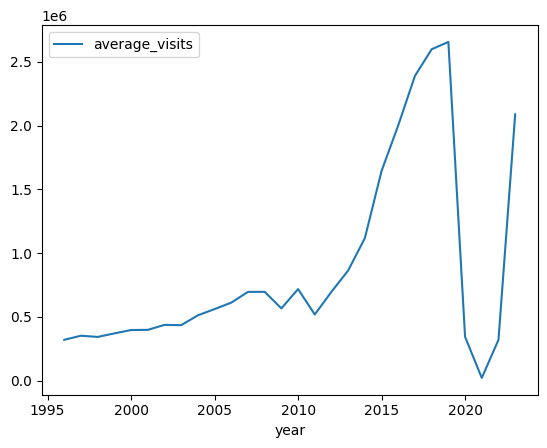

In [7]:
jpvisitssimp_df.plot(x='year', y='average_visits', kind='line')  # Change 'line' to other types like 'bar', 'scatter', etc.
plt.show()

In [8]:
# Add visits to japan (yearly) column to the anime dataset - only between 1996 an 2023 inclusive.

anime_df['affect_on_jpvisits'] = 0
for row in range(0, anime_df.shape[0]):

    # Set any anime with start year before 1995 (inclusive) to 0 to match the jpvisits years.
    if anime_df['Aired_start'][row] <= 1995:
        anime_df['affect_on_jpvisits'][row] = 0

    # Calculate votes to visits ratio, meaning how many votes lead to one visit.
    #   For up to one year runtime:
    elif anime_df['Aired_start'][row] == anime_df['Aired_end'][row]:
        visits = jpvisitssimp_df['average_visits'][jpvisitssimp_df['year'] == anime_df['Aired_start'][row]].tolist()[0]
        votes_to_visits_ratio = anime_df['Votes'][row] / visits
        anime_df['affect_on_jpvisits'][row] = votes_to_visits_ratio
    #   For more than one year runtime:
    else:
        for year in range(anime_df['Aired_start'][row], anime_df['Aired_end'][row]):
            visits_list = []
            visits = jpvisitssimp_df['average_visits'][jpvisitssimp_df['year'] == year].tolist()[0]
            visits_list.append(visits)
            visits_sum = sum(visits_list)
            votes_to_visits_ratio = anime_df['Votes'][row] / visits_sum
            anime_df['affect_on_jpvisits'][row] = votes_to_visits_ratio


/var/folders/fx/_v41s7jd6_z_rsjqbd_t4sw80000gn/T/ipykernel_48997/1682702148.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_df['affect_on_jpvisits'][row] = votes_to_visits_ratio


In [9]:
qt_votes = QuantileTransformer(n_quantiles=10, random_state=0)
anime_df['Votes'] = qt_votes.fit_transform(anime_df[['Votes']])

In [10]:
qt_affects = QuantileTransformer(n_quantiles=10, random_state=0)
anime_df['affect_on_jpvisits'] = qt_affects.fit_transform(anime_df[['affect_on_jpvisits']])

In [11]:
qt_visits = QuantileTransformer(n_quantiles=10, random_state=0)
jpvisitssimp_df['average_visits'] = qt_visits.fit_transform(jpvisitssimp_df[['average_visits']])

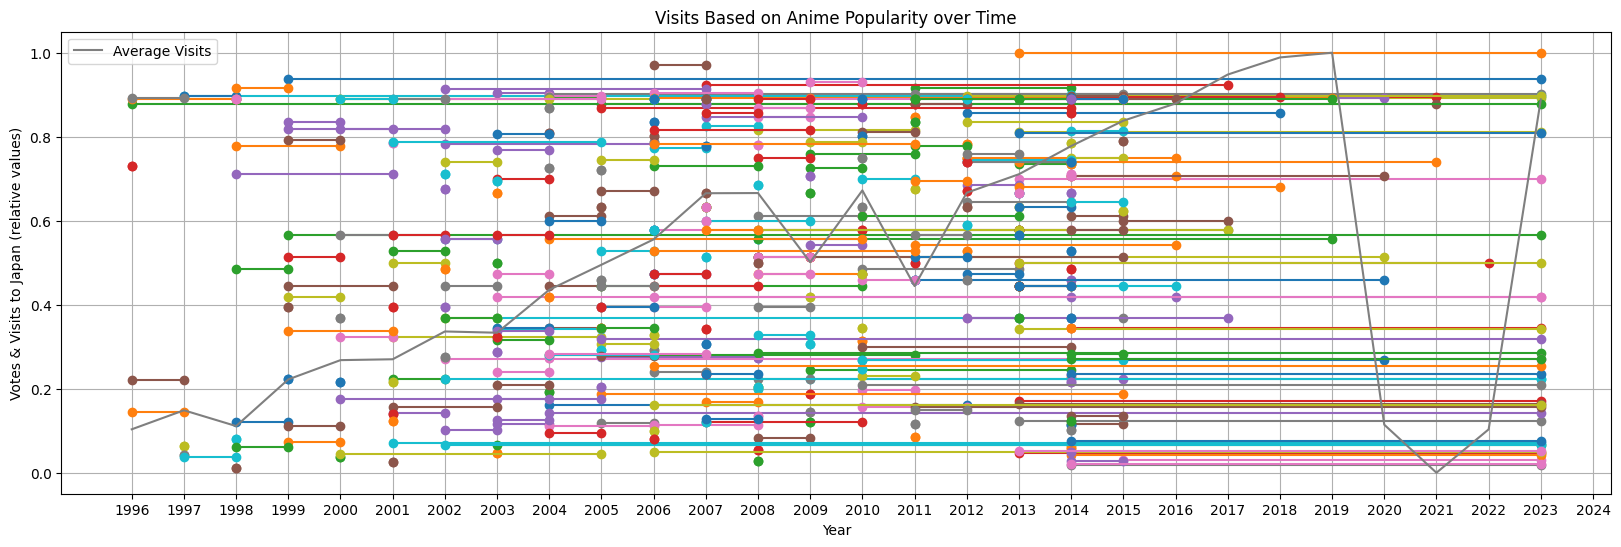

In [12]:
# Plot the all anime popularities and visits to japan.

plt.figure(figsize = (20, 6))

for row_index in anime_df.index:  # You can change this to plot different rows
    if anime_df['Aired_start'][row_index] >= 1996:
        row_data = anime_df['Votes'][row_index]
        start_year = anime_df['Aired_start'][row_index]
        end_year = anime_df['Aired_end'][row_index]
        # Plotting
        plt.plot([start_year, end_year], [row_data, row_data], marker='o')
plt.plot(jpvisitssimp_df['year'], jpvisitssimp_df['average_visits'], label='Average Visits')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Votes & Visits to Japan (relative values)')
plt.title('Visits Based on Anime Popularity over Time')
plt.xticks(range(1996, 2025))  # Set x-axis ticks to start_year and end_year
plt.grid(True)
plt.show()


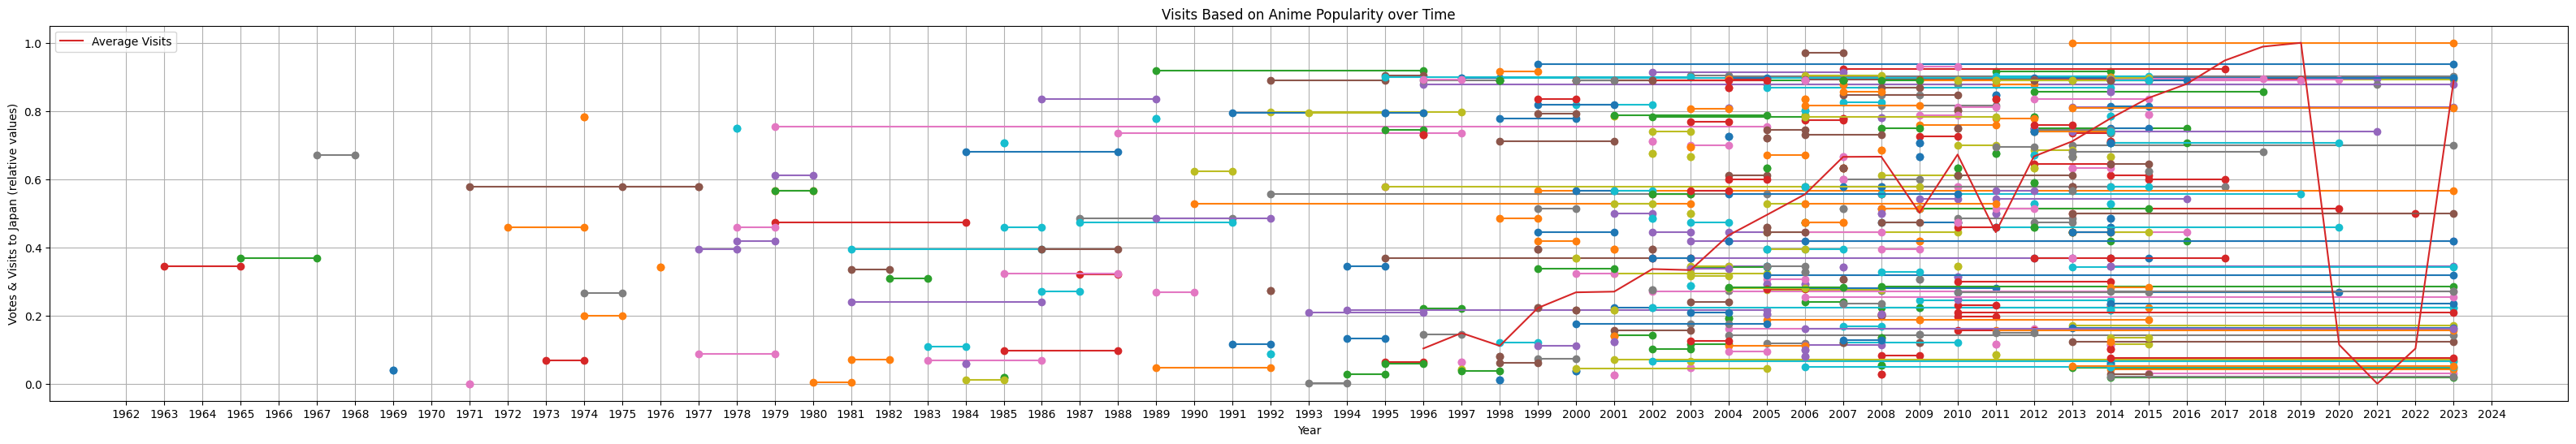

In [13]:
# Plot the all anime popularities and visits to japan.

plt.figure(figsize = (40, 6))

for row_index in anime_df.index:  # You can change this to plot different rows
    row_data = anime_df['Votes'][row_index]
    start_year = anime_df['Aired_start'][row_index]
    end_year = anime_df['Aired_end'][row_index]
    # Plotting
    plt.plot([start_year, end_year], [row_data, row_data], marker='o')
plt.plot(jpvisitssimp_df['year'], jpvisitssimp_df['average_visits'], label='Average Visits')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Votes & Visits to Japan (relative values)')
plt.title('Visits Based on Anime Popularity over Time')
plt.xticks(range(1962, 2025))  # Set x-axis ticks to start_year and end_year
plt.grid(True)
plt.show()


In [14]:
# In the anime dataset, calculate the number of years on air and make it into a new column.

anime_df['Years_on_air'] = 0
for row in range(0, anime_df.shape[0]):
    if anime_df['Aired_end'][row] - anime_df['Aired_start'][row] == 0:
        anime_df['Years_on_air'][row] = 1
    else:
        new_col = anime_df['Aired_end'][row] - anime_df['Aired_start'][row]
        anime_df['Years_on_air'][row] = new_col

/var/folders/fx/_v41s7jd6_z_rsjqbd_t4sw80000gn/T/ipykernel_48997/2221748554.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_df['Years_on_air'][row] = new_col
/var/folders/fx/_v41s7jd6_z_rsjqbd_t4sw80000gn/T/ipykernel_48997/2221748554.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_df['Years_on_air'][row] = 1


In [15]:
# Separate the genres into separate columns from the Genre column.
# One hot encode the genres.

genres = anime_df['Genre'].str.get_dummies(sep=', ')
animeencoded_df = pd.concat([anime_df, genres], axis=1)

# Drop any genre that has no value.
animeencodedgenre_df = animeencoded_df.dropna(subset=['Genre'])

In [16]:
# Drop genre columns that have less than 10 entries.

animeencodedcleanedgenre_df = animeencodedgenre_df
for g in genres.columns.tolist():
    if sum(animeencodedcleanedgenre_df[g]) < 10:
        animeencodedcleanedgenre_df = animeencodedcleanedgenre_df.drop(g, axis=1)

In [200]:
# TEST SAMPLE

anime_df_test = animeencodedcleanedgenre_df.sample(n=1)
anime_df_test_indx = int(anime_df_test.index[0])

In [201]:
# Remove the TEST SAMPLE that'll be used as prediction from the dataset.

animeencodedcleanedgenre_df = animeencodedcleanedgenre_df.drop([anime_df_test_indx])

# Define X and Y:
#   Genre types, votes, and total years on air as input
#   Precentage of affecting travelling to japan as output.

dataX = animeencodedcleanedgenre_df.drop(['Name', 'Type', 'Aired', 'Rating', 'Votes', 'Discription', 'Studio',
       'Genre', 'Aired_start', 'Aired_end', 'affect_on_jpvisits'], axis=1)
dataY = animeencodedcleanedgenre_df['affect_on_jpvisits']

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# train is now 70% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train_ratio)

# test is now 15% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

In [202]:
# Balance the train datasets.

# Concatenate the features and target variable
data = np.concatenate((x_train, y_train.values.reshape(-1, 1)), axis=1)

# Separate by target values
high_target = data[data[:, -1] > np.median(y_train)]  # For example, high target values
low_target = data[data[:, -1] <= np.median(y_train)]  # For example, low target values

# Resample the high target group to balance the dataset
high_target_upsampled = resample(high_target,
                                 replace=True,
                                 n_samples=len(low_target),
                                 random_state=42)

# Combine with the low target group
balanced_data = np.vstack((low_target, high_target_upsampled))

# Split features and target
X_balanced = balanced_data[:, :-1]
y_balanced = balanced_data[:, -1]


In [203]:
# Build the model.

animeencodedcleaned_df_test = anime_df_test

x_new = animeencodedcleaned_df_test.drop(['Name', 'Type', 'Aired', 'Rating', 'Votes', 'Discription', 'Studio',
       'Genre', 'Aired_start', 'Aired_end', 'affect_on_jpvisits'], axis=1)

# Step 3: Choose a Model and Train
model = LinearRegression()  # Example: Linear Regression
# model.fit(x_train, y_train)
model.fit(X_balanced, y_balanced)

# Step 4: Model Evaluation
val_predictions = model.predict(x_val)
val_mse = mean_squared_error(y_val, val_predictions)
print("Validation Mean Squared Error:", val_mse)

# Step 6: Final Evaluation
test_predictions = model.predict(x_test)
test_mse = mean_squared_error(y_test, test_predictions)
print("Test Mean Squared Error:", test_mse)

# score = model.score(x_train, y_train)
score = model.score(X_balanced, y_balanced)
print("Model Score:", score)

# Step 7: Prediction on new data
new_predictions = model.predict(x_new)
new_predictions

print(f"\n**** With the dataset we have,\nwe can predict around %{round(score*100, 2)} of the influence of anime series on trips to Japan:\nIf a new anime is introduced in the genre of\n{animeencodedcleaned_df_test['Genre'][anime_df_test_indx]}\nand stays on the air for\n{animeencodedcleaned_df_test['Years_on_air'][anime_df_test_indx]} year(s),\nwe can say that it has\n{round(new_predictions[0]*100, 2)} percent chance of encouraging foreigners to visit Japan! ****")


Validation Mean Squared Error: 0.08514663128073074
Test Mean Squared Error: 0.09016448819155527
Model Score: 0.22571179023965438

**** With the dataset we have,
we can predict around %22.57 of the influence of anime series on trips to Japan:
If a new anime is introduced in the genre of
Comedy, Drama, Romance
and stays on the air for
3 year(s),
we can say that it has
46.84 percent chance of encouraging foreigners to visit Japan! ****


/Users/seyedsaidafghah/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/seyedsaidafghah/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/seyedsaidafghah/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [187]:
# model.coef_
pd.concat([pd.DataFrame(animeencodedcleaned_df_test.columns),pd.DataFrame(np.transpose(model.coef_))], axis = 1)

,0,0
0,Name,-0.002955
1,Type,0.002977
2,Aired,-0.038153
3,Rating,-0.045354
4,Votes,0.117682
5,Discription,0.138808
6,Studio,-0.029099
7,Genre,-0.048507
8,Aired_start,0.058715
9,Aired_end,0.057378


In [98]:
model.intercept_

0.4980878045913447

## RUN TO SAVE MODEL

In [140]:
# # **** DO NOT RUN AGAIN! ****
# # Or change file name to avoid overwriting the existing saved model.

# filename = "Completed_model_aug3.joblib"
# joblib.dump(model, filename)

['Completed_model_aug3.joblib']

In [165]:
# process_new_anime(user_genres:list, user_years:int)
# user_genres = ['Adventure', 'Science Fiction']
user_genres = ['Coming-of-age', 'Horror']
user_years = 1


d = {'Years_on_air': [user_years]}
user_df = pd.DataFrame(data=d)

genre_columns = ['Action', 'Adventure', 'Comedy', 'Coming-of-age',
       'Dark fantasy', 'Drama', 'Fantasy', 'Harem', 'Historical', 'Horror',
       'Martial arts', 'Mecha', 'Mystery', 'Post-apocalyptic', 'Psychological',
       'Romance', 'Science Fiction', 'Slice of life', 'Space opera', 'Sports',
       'Supernatural', 'Suspense', 'Thriller']
new = pd.DataFrame()
for col in genre_columns:
    new[[f'{col}']] = pd.DataFrame([[0]], index=user_df.index)

user_df = pd.concat([user_df, new], axis=1)

# for g in user_genres:
#     user_df[g] = user_df[g].map({g: 1})

for g in user_genres:
    g_column = user_df[g]
    new_g_column = 1
    user_df[g] = new_g_column

loaded_model = joblib.load("Completed_model_aug3.joblib")

new_predictions = loaded_model.predict(user_df)
# new_predictions = model.predict(user_df)
# new_predictions

print(f"\n**** With the dataset we have,\nWe can predict around %32 of the influence of anime series on trips to Japan:\nIf a new anime is introduced in the genre of\n{user_genres}\nand stays on the air for\n{user_years} year(s),\nwe can say that it has\n{round(new_predictions[0]*100, 2)} percent chance of encouraging foreigners to visit Japan! ****")



**** With the dataset we have,
We can predict around %32 of the influence of anime series on trips to Japan:
If a new anime is introduced in the genre of
['Coming-of-age', 'Horror']
and stays on the air for
1 year(s),
we can say that it has
61.49 percent chance of encouraging foreigners to visit Japan! ****


/Users/seyedsaidafghah/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [81]:
user_df

,Years_on_air,Action,Adventure,Comedy,Coming-of-age,Dark fantasy,Drama,Fantasy,Harem,Historical,...,Post-apocalyptic,Psychological,Romance,Science Fiction,Slice of life,Space opera,Sports,Supernatural,Suspense,Thriller
0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# What is MISSING from data above:
## The votes are overall, and we cannot see how the votes (aka popularity) changed overtime. So it is assumed it's remained unchaged.
## Model accuracy is at %32, meaning with the dataset we have, we can predict around %32 of the influence of anime series on trips to Japan.

In [ ]:
# FOR STREAMLIT:
# make a model with genre types and votes and years on air as input and precentage of affecting travelling to japan as output.